In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import os
import json
import matplotlib
import os
from IPython.display import display
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots


matplotlib.use("pdf")
os.chdir("/home/isevillano/Github/SHIELD/docs/")

# Comparativa Accuracy y Loss

In [5]:
df = pd.DataFrame(columns=['Dataset','Regularization','Percentage', 'Model','Test/Accuracy','Test/Loss'])

for dataset in os.listdir("../results/"):
    
    for experiment in os.listdir(f"../results/{dataset}/"):
        event_acc = EventAccumulator(f"../results/{dataset}/{experiment}/")
        config_file = json.load(open(f"../results/{dataset}/{experiment}/config.json"))
        event_acc.Reload()
        
        Test_Acc = None
        Test_Loss = None
        regularization = ""
        
        if "Test/Accuracy" in event_acc.Tags()["scalars"]:
            Test_Acc = event_acc.Scalars("Test/Accuracy")[-1].value
        
        if "Test/Loss" in event_acc.Tags()["scalars"]:
            Test_Loss = event_acc.Scalars("Test/Loss")[-1].value
        
        if config_file["xshield"]:
            regularization = "X-SHIELD"
        if config_file["shield"]:
            regularization = "SHIELD"
        if regularization == "":
            regularization = "Baseline"
        df = pd.concat([df, pd.DataFrame({"Dataset": dataset, 
                                        "Regularization": regularization,
                                        "Model":config_file["pretrained_model"],
                                        "Test/Accuracy": Test_Acc,
                                        "Test/Loss": Test_Loss,
                                        "Percentage": config_file["percentage"]}, index=[0])], ignore_index=True)

/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"Dataset": dataset,
/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"Dataset": dataset,
/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determ

/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"Dataset": dataset,
/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"Dataset": dataset,
/tmp/ipykernel_26938/2091857832.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determ

In [6]:
df_latex = df.copy()
df_latex.rename(
    columns={
        "Dataset": "Dataset",
        "Percentage": "Percentage",
        "Model": "Model",
        "Test/Accuracy": "Accuracy",
        "Test/Loss": "Loss",
    },
    inplace=True,
)

df_latex = df_latex[df_latex["Regularization"].isin(["Baseline", "X-SHIELD", "SHIELD"])]
df_latex = df_latex[df_latex["Model"].isin(["efficientnet-b2", "efficientnet_v2_s"])]
df_latex["Accuracy"] = df_latex["Accuracy"].round(4)
df_latex["Loss"] = df_latex["Loss"].round(4)
df_latex = df_latex.sort_values(by=["Dataset", "Model", "Percentage", "Regularization"])

df_latex["Accuracy"] = (
    (df_latex["Accuracy"] * 100)
    .round(2)
    .map(lambda x: f"{x}\%")
    .map(lambda x: x.replace(".", ","))
)
df_latex["Loss"] = (
    df_latex["Loss"].round(4).map(lambda x: f"{x}").map(lambda x: x.replace(".", ","))
)

df_latex[["Accuracy", "Loss"]].to_csv("results.csv", index=False, sep=";")

df_latex["Percentage"] = df_latex["Percentage"].map(lambda x: f"{int(x)}\%")
df_latex = df_latex[
    ["Dataset", "Model", "Percentage", "Regularization", "Accuracy", "Loss"]
]
df_latex["Model"] = df_latex["Model"].map(lambda x: x.replace("_", " "))
df_latex["Model"] = df_latex["Model"].map(lambda x: x.replace("-", " "))

for dataset in df_latex["Dataset"].unique():
    df_ds = df_latex[df_latex["Dataset"] == dataset].drop(columns=["Dataset"])
    # df_ds = df_ds.drop(columns=["Model"])
    # Ordenar df_ds primero por modelo y luego por porcentaje

    df_ds.to_latex(
        f"tables/{dataset}_X-SHIELD.tex",
        index=False,
        escape=False,
        column_format="llccc",
    )

# Métricas REVEL

In [7]:
cols = plotly.colors.DEFAULT_PLOTLY_COLORS
metrics = ["Local_Concordance",
    "Local_Fidelity",
    "Prescriptivity",
    "Conciseness",
    "Robustness"]

bigDf = []
for dataset in os.listdir("../results/"):
    for experiment in os.listdir(f"../results/{dataset}/"):
        # Si existe el archivo "metrics.csv" en el directorio, leerlo
        if os.path.exists(f"../results/{dataset}/{experiment}/metrics.csv"):
            config = json.load(open(f"../results/{dataset}/{experiment}/config.json"))
            df = pd.read_csv(f"../results/{dataset}/{experiment}/metrics.csv")
            
            df["Regularization"] = "SHIELD" if config["shield"] else "X-SHIELD" if config["xshield"] else "Baseline"
            df["Percentage"] = config["percentage"]
            df["Model"] = config["pretrained_model"]
            bigDf.append(df)
        # Si no existe, escribir por pantalla cuál es
        else:
            print(f"No metrics.csv in {experiment} on {dataset} with {config['pretrained_model']} and {config['percentage']}% of hiding.")
    
bigDf = pd.concat(bigDf)
bigDf["Robustness"] = bigDf["robustness"]
bigDf["Conciseness"] = bigDf["conciseness"]
bigDf["Prescriptivity"] = bigDf["prescriptivity"]
bigDf["Local_Fidelity"] = bigDf["local_fidelity"]
bigDf["Local_Concordance"] = bigDf["local_concordance"]
# Eliminar el anterio Experiments.csv
if os.path.exists("Experiments.csv"):
    os.remove("Experiments.csv")
bigDf.drop(columns=["robustness","conciseness","prescriptivity","local_fidelity","local_concordance","name"], inplace=True)
bigDf.dropna(inplace=True)
#bigDf = bigDf[bigDf["index"] <100]
bigDf = bigDf.groupby(["Model","dataset","index","Regularization","Percentage"]).mean().reset_index().to_csv("Experiments_mean.csv", index=False) 

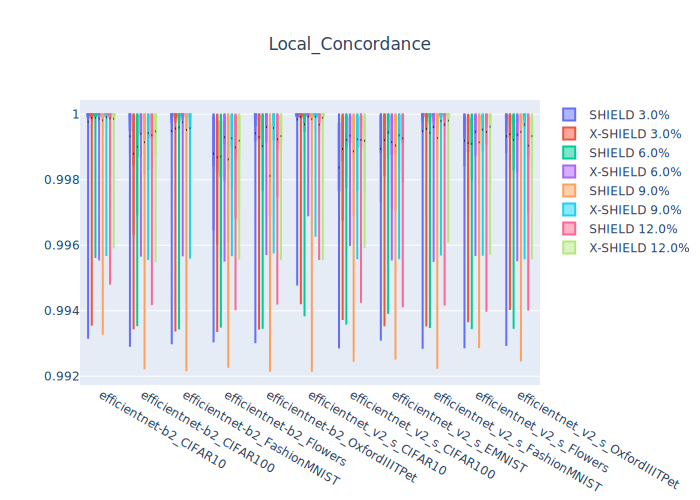

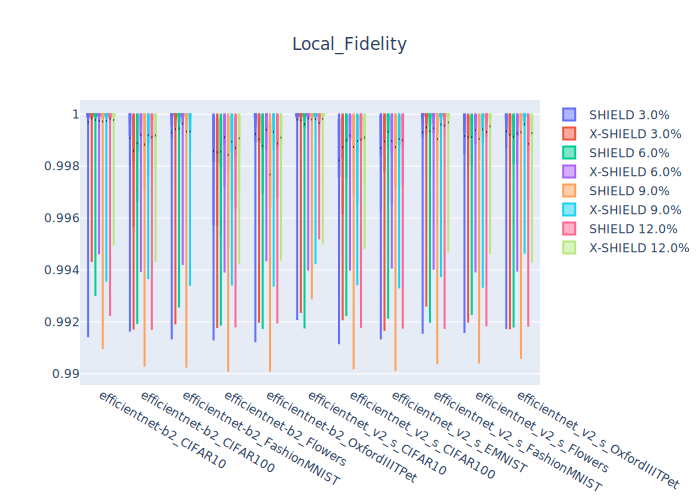

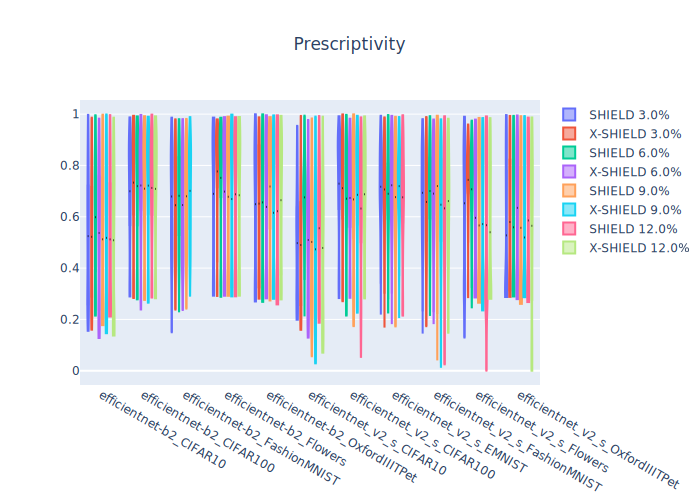

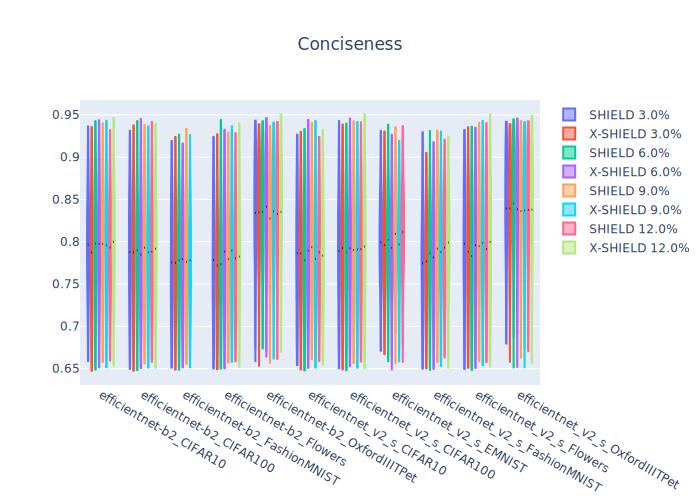

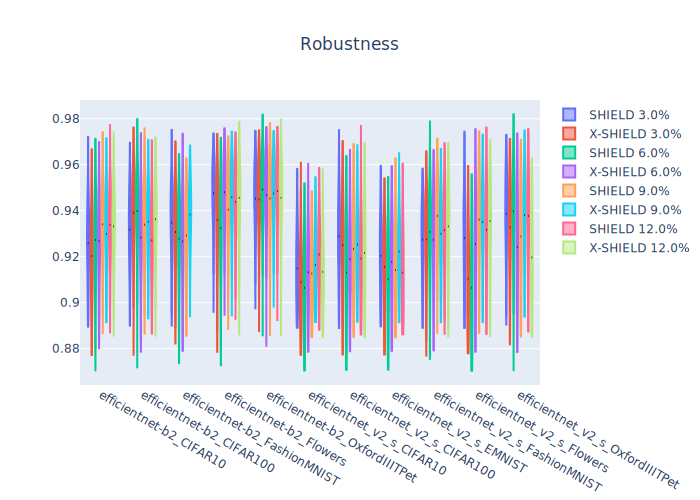

In [8]:
res = pd.read_csv("Experiments_mean.csv")
res = res[res["Regularization"].isin(["SHIELD", "X-SHIELD"])]
res = res[res["Model"].isin(["efficientnet-b2", "efficientnet_v2_s"])]
for metric in metrics:
    lista_figuras = []
    for j,percentage in enumerate(res["Percentage"].unique()):
        res_reg = res[res["Percentage"] == percentage]
        for k, regularization in enumerate(res["Regularization"].unique()): 
            df = res_reg[res_reg["Regularization"] == regularization]
            median = df[metric].quantile(0.5)
            RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
            df_show = df[(df[metric] > median - 1.5*RIQ) & (df[metric] < median + 1.5*RIQ)]
            figura = go.Violin(x = df_show["Model"]+"_"+df_show["dataset"],
                               y = df_show[metric],
                               name = f"{regularization} {percentage}%",
                               box_visible = True,
                               spanmode = "hard",
                               meanline_visible = True,
                               meanline_color = "black",
                               meanline_width = 2,
                               points = False)
            lista_figuras.append(figura)
    fig = go.Figure(data = lista_figuras)
    fig.update_layout(title = metric,
                    title_x = 0.5,
                    violinmode = "group")
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_violin.pdf",width=1000,height=500)

# Test Bayesiano SHIELD vs X-SHIELD

In [17]:
import numpy as np
import pandas as pd
import matplotlib

matplotlib.use("pdf")
import baycomp

df = pd.read_csv("Experiments_mean.csv")
df = df[df["Regularization"].isin(["SHIELD", "X-SHIELD"])]
#df = df[df["index"] < 100]


df_shield = df[df["Regularization"] == "SHIELD"]
df_xshield = df[df["Regularization"] == "X-SHIELD"]

# Nos quedamos con la intersección de los dataset donde "Model", "dataset", "Percentage" y "index" son iguales
df_instersection = df_shield.merge(df_xshield, on=["Model", "dataset", "Percentage", "index"], suffixes=["_shield", "_xshield"])


# Para cada métrica, comparamos los resultados de SHIELD y X-SHIELD con un test de Bayes con un rope igual al
# 5% de la diferencia de las medias
for percentage in df_instersection["Percentage"].unique():
    df_percentage = df_instersection[df_instersection["Percentage"] == percentage]
    for metric in metrics:
        rope = np.quantile(np.abs(df_percentage[metric+"_shield"] - df_percentage[metric+"_xshield"]), 0.20)
        SHIELD = df_percentage[metric+"_shield"]
        XSHIELD = df_percentage[metric+"_xshield"]
        bayes_test = baycomp.SignTest(SHIELD, XSHIELD,rope=rope,nsamples=100000)
        
        bayes_test.plot(names=["SHIELD", "XSHIELD"]).savefig(f"./imagenes/Bayes/{metric}_{percentage}.pdf", bbox_inches="tight", dpi=300,
                                                            transparent=True,
                                                            pad_inches=0,
                                                            )


    